# RAPIDS & Scanpy Single-Cell RNA-seq Workflow on PFC cells

Copyright (c) 2020, NVIDIA CORPORATION.

Licensed under the Apache License, Version 2.0 (the "License") you may not use this file except in compliance with the License. You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0 

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

This notebook demonstrates a single-cell RNA analysis workflow that begins with preprocessing a count matrix of size `(n_gene, n_cell)` and results in a visualization of the clustered cells for further analysis.

For demonstration purposes, we use a dataset of 1.3 M brain cells with Unified Virtual Memory to oversubscribe GPU memory.

## Import requirements

In [1]:
import numpy as np
import scanpy as sc
import anndata
import scipy.io
import scipy.sparse

import time
import os, wget


import cudf

from cuml.decomposition import PCA
from cuml.manifold import TSNE
from cuml.cluster import KMeans
from cuml.preprocessing import StandardScaler

import cuml
import rapids_scanpy_funcs
import utils

import warnings
warnings.filterwarnings('ignore', 'Expected ')
warnings.simplefilter('ignore')
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import rmm

from rmm.allocators.cupy import rmm_cupy_allocator
import cupy
cupy.cuda.set_allocator(rmm_cupy_allocator)
from scipy import sparse
import gc
import cupy as cp
gc.collect()
cp.get_default_memory_pool().free_all_blocks()

We use the RAPIDS memory manager to enable Unified Virtual Memory management, which allows us to oversubscribe the GPU memory.

In [1]:
import rmm
rmm.reinitialize(managed_memory=True)
from rmm.allocators.cupy import rmm_cupy_allocator
import cupy
cupy.cuda.set_allocator(rmm_cupy_allocator)

## Input data

In the cell below, we provide the path to the sparse `.h5ad` file containing the count matrix to analyze. Please see the README for instructions on how to download the dataset we use here.

To run this notebook using your own dataset, please see the README for instructions to convert your own count matrix into this format. Then, replace the path in the cell below with the path to your generated `.h5ad` file.

In [ ]:

mtx_path=r"/temp/data/human_MDD_PFC/GSE144136_GeneBarcodeMatrix_Annotated.mtx"
cell_name_path=r"/temp/data/human_MDD_PFC/GSE144136_CellNames.csv"
gene_name_path=r"/temp/data/human_MDD_PFC/GSE144136_GeneNames.csv"

genes = pd.read_csv(gene_name_path)
cells = pd.read_csv(cell_name_path)
adata=sc.read_mtx(mtx_path)
adata=adata.T
adata.obs_names = cells.x
adata.var_names = genes.x
adata.X=sparse.csr_matrix(adata.X)
adata.write("/temp/data/human_MDD_PFC/merged_data.h5ad")
#arr = scipy.io.mmread(mtx_path).tocsr()

In [ ]:
print(adata.X)
#print(adata.obs_names)
print(genes.x)

In [ ]:
celltype_df=pd.DataFrame(cells.x.str.split(".",expand=True))
barcode_df=celltype_df.iloc[:,1].str.split("_",expand=True)
barcode_df2=pd.concat([celltype_df.iloc[:,0],barcode_df],axis=1)
barcode_df2=barcode_df2.set_axis(["celltype","subject","case_control","batch","barcode"],axis="columns")
b_df3=barcode_df2.copy()
b_df3.index=adata.obs.index
obs_col=["celltype","subject","case_control","batch","barcode"]

preprocess_in_bulk
['CX3CR1', 'CLDN5', 'GLUL', 'NDRG2', 'PCDH15', 'PLP1', 'MBP', 'SATB2', 'SLC17A7', 'SLC17A6', 'GAD2', 'GAD1', 'SNAP25', 'HTR1A', 'HTR1B', 'HTR1D', 'HTR1E', 'HTR2A', 'HTR2B', 'HTR2C', 'HTR3A', 'HTR4', 'HTR5A', 'HTR6', 'HTR7', 'DRD1', 'DRD2', 'DRD3', 'DRD4', 'DRD5', 'HRH1', 'HRH2', 'HRH3', 'CHRM1', 'CHRM2', 'CHRM3', 'CHRM4', 'CHRM5', 'ADRA1A', 'ADRA1B', 'ADRA2A', 'ADRA2B', 'ADRA2C', 'ADRB1', 'ADRB2']
perform regression
perform scale
float32
Total Preprocessing time: 24.627025842666626
shape of adata: (35184, 29432)
shape of adata: (35184, 29432)
perform PCA
10
t-sne
UMAP
[2025-04-04 23:25:18.498] [CUML] [info] build_algo set to brute_force_knn because random_state is given
UMAP louvain


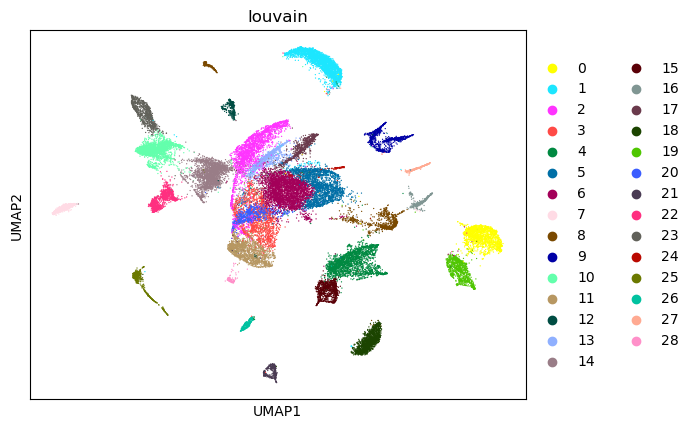

UMAP leiden


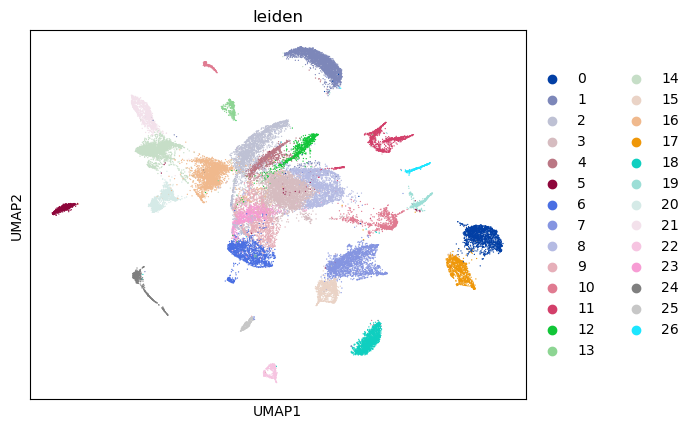

calc drug response
clz selective cells
# of clz selective cells: is_clz_selective
False    31217
True      3967
Name: count, dtype: int64


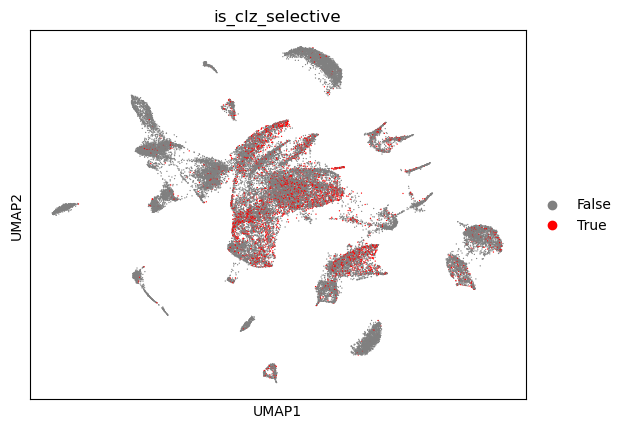

In [2]:
import calculation_tool as ct
file_path="/data/human_MDD_PFC/merged_control_data.h5ad"
adata,GPCR_df=ct.preprocess_adata_in_bulk(file_path,label=None,is_gpu=False)
GPCR_df.to_csv("/data/human_MDD_PFC/combined_data_GPCR_df.csv")

In [ ]:
file_path="/data/human_MDD_PFC/merged_control_data.h5ad"
adata=anndata.read_h5ad(file_path)

Drug concentration: 0.001
clz selective cells
# of clz selective cells: is_clz_selective
False    34503
True       681
Name: count, dtype: int64


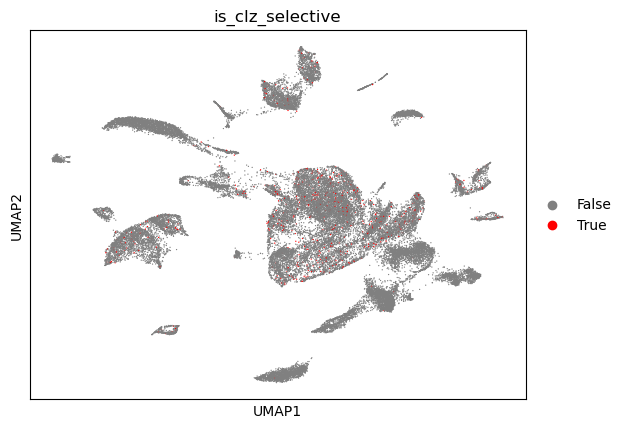

Drug concentration: 0.01
clz selective cells
# of clz selective cells: is_clz_selective
False    34503
True       681
Name: count, dtype: int64


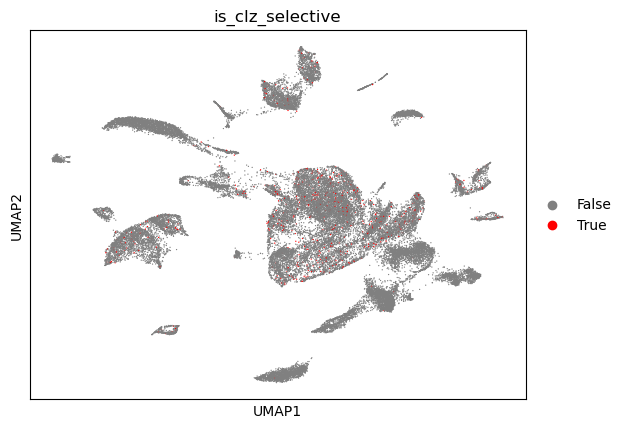

Drug concentration: 0.1
clz selective cells
# of clz selective cells: is_clz_selective
False    34503
True       681
Name: count, dtype: int64


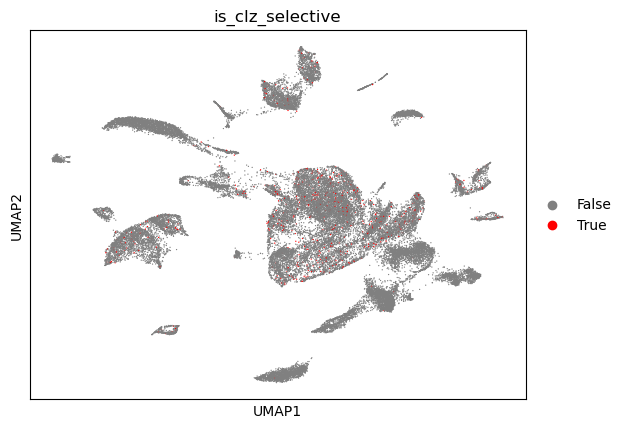

Drug concentration: 1
clz selective cells
# of clz selective cells: is_clz_selective
False    34481
True       703
Name: count, dtype: int64


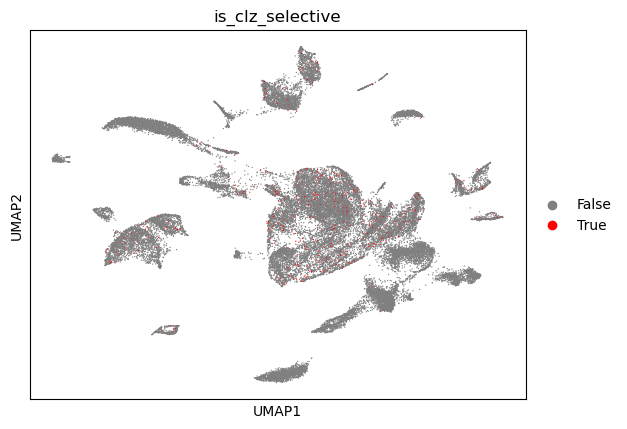

Drug concentration: 1.5848931924611136
clz selective cells
# of clz selective cells: is_clz_selective
False    34445
True       739
Name: count, dtype: int64


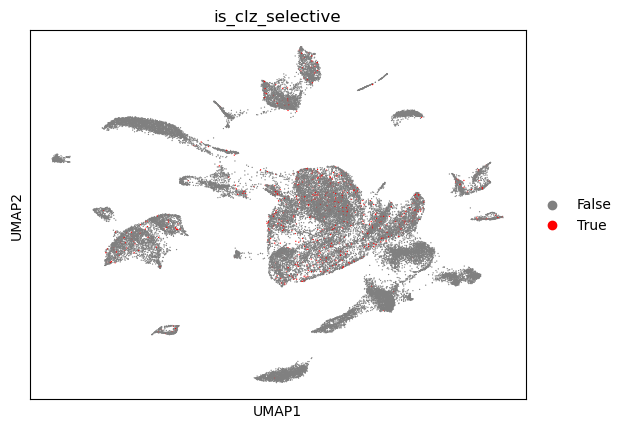

Drug concentration: 2.2387211385683394
clz selective cells
# of clz selective cells: is_clz_selective
False    34374
True       810
Name: count, dtype: int64


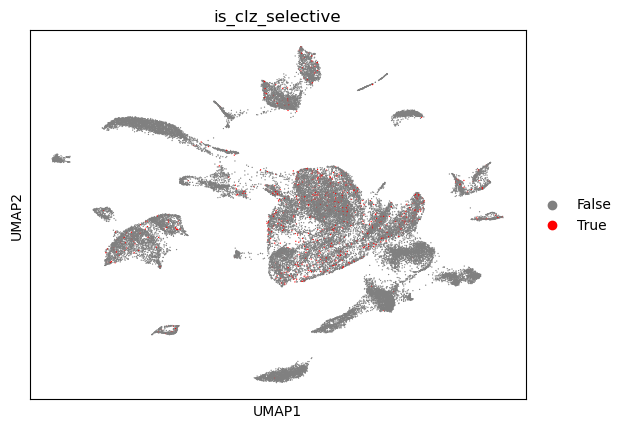

Drug concentration: 3.1622776601683795
clz selective cells
# of clz selective cells: is_clz_selective
False    33881
True      1303
Name: count, dtype: int64


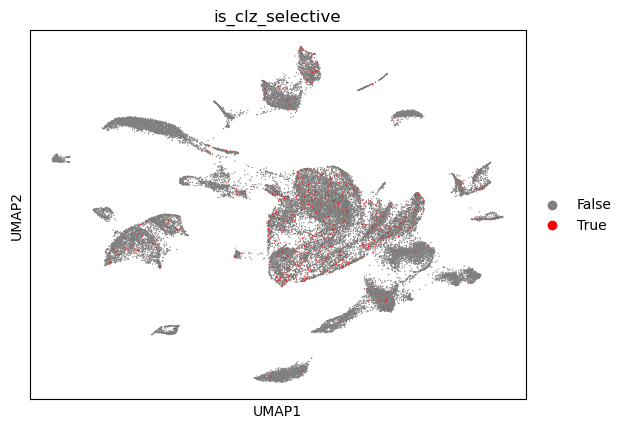

Drug concentration: 5.623413251903491
clz selective cells
# of clz selective cells: is_clz_selective
False    33804
True      1380
Name: count, dtype: int64


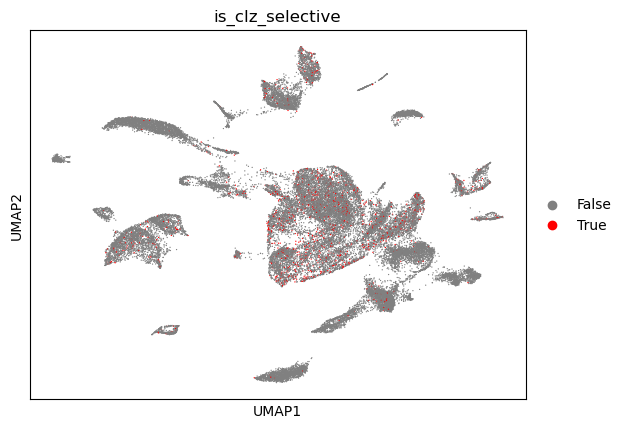

Drug concentration: 10
clz selective cells
# of clz selective cells: is_clz_selective
False    33608
True      1576
Name: count, dtype: int64


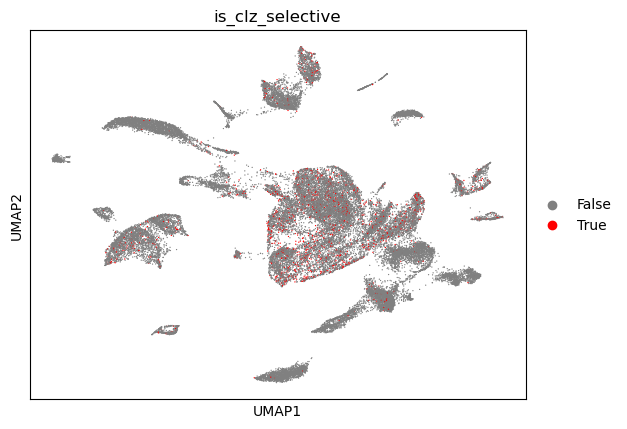

Drug concentration: 31.622776601683793
clz selective cells
# of clz selective cells: is_clz_selective
False    33234
True      1950
Name: count, dtype: int64


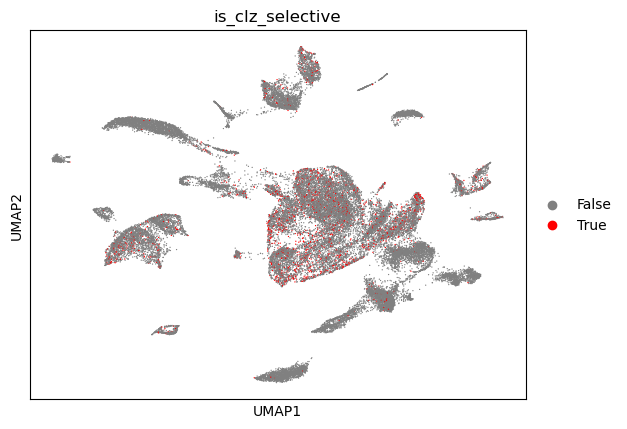

Drug concentration: 100
clz selective cells
# of clz selective cells: is_clz_selective
False    31518
True      3666
Name: count, dtype: int64


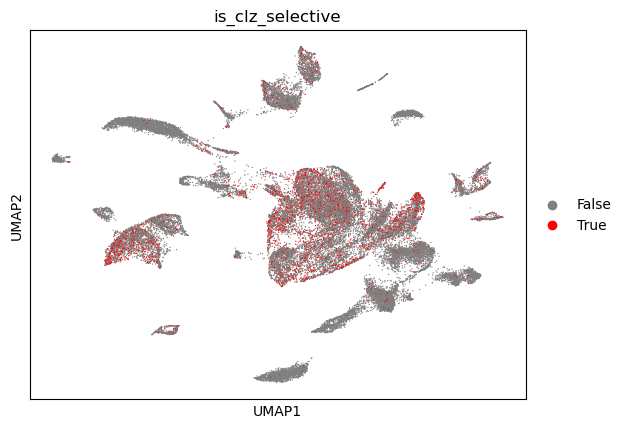

Drug concentration: 316.22776601683796
clz selective cells
# of clz selective cells: is_clz_selective
False    31252
True      3932
Name: count, dtype: int64


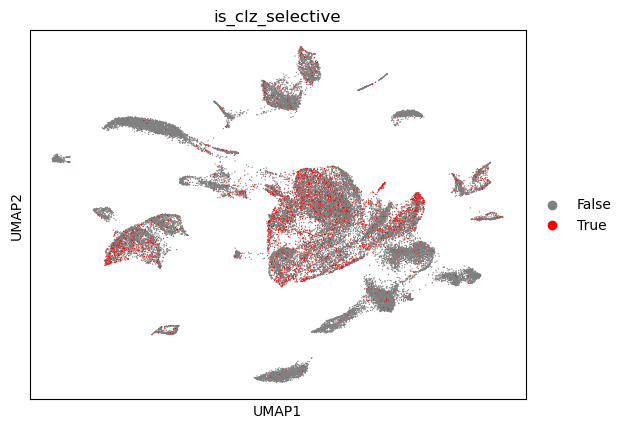

Drug concentration: 1000
clz selective cells
# of clz selective cells: is_clz_selective
False    31002
True      4182
Name: count, dtype: int64


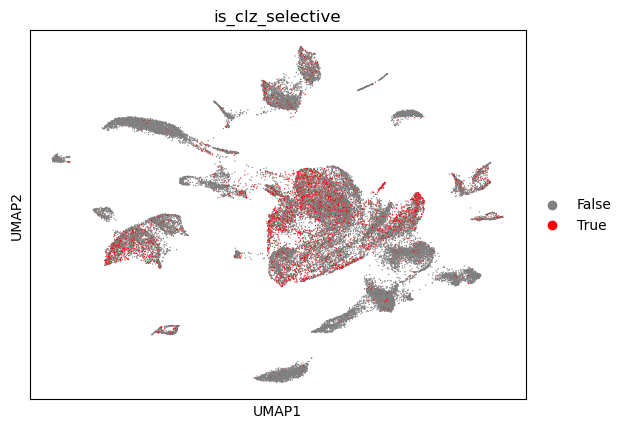

Drug concentration: 10000
clz selective cells
# of clz selective cells: is_clz_selective
False    31633
True      3551
Name: count, dtype: int64


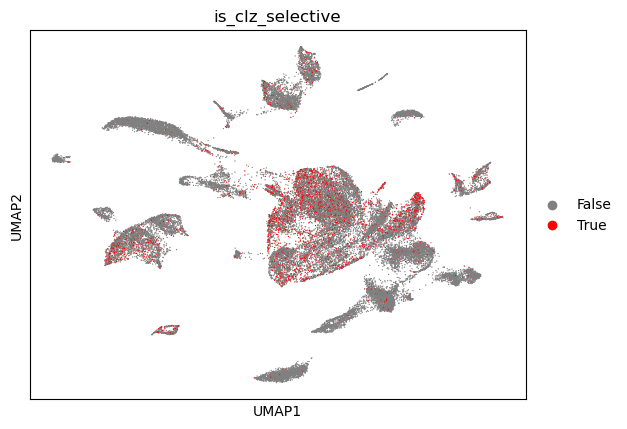

Drug concentration: 100000
clz selective cells
# of clz selective cells: is_clz_selective
False    32503
True      2681
Name: count, dtype: int64


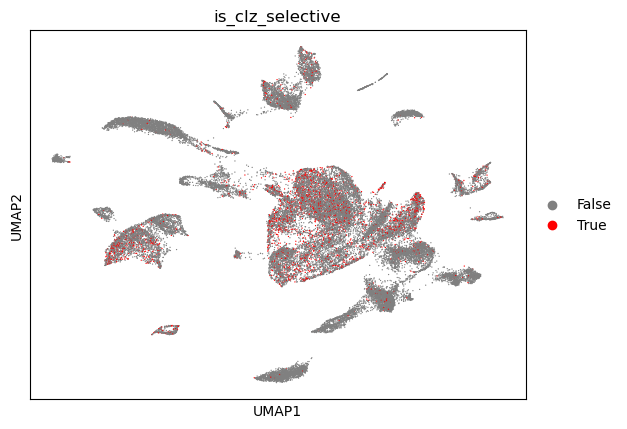

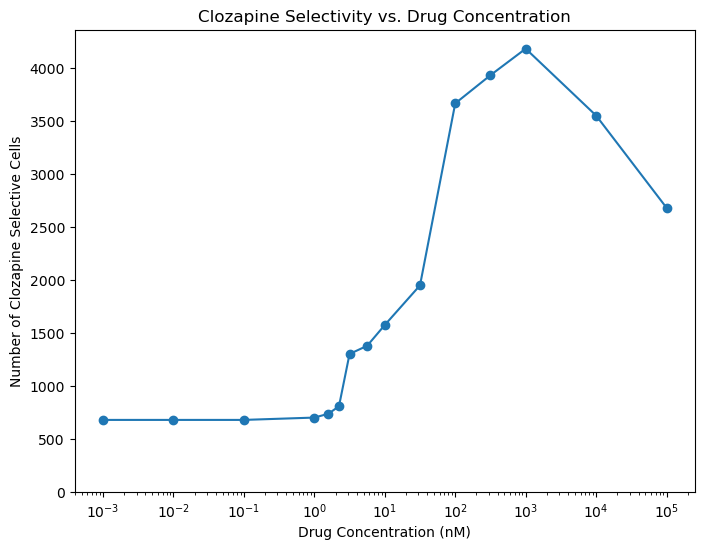

In [3]:
D_R_mtx,GPCR_type_df,drug_list,GPCR_list=ct.load_parameters()
params=ct.set_parameters_for_preprocess(GPCR_list)
import calculation_tool as ct
ct.drug_titeration(adata, GPCR_df, GPCR_type_df, drug_list, D_R_mtx)

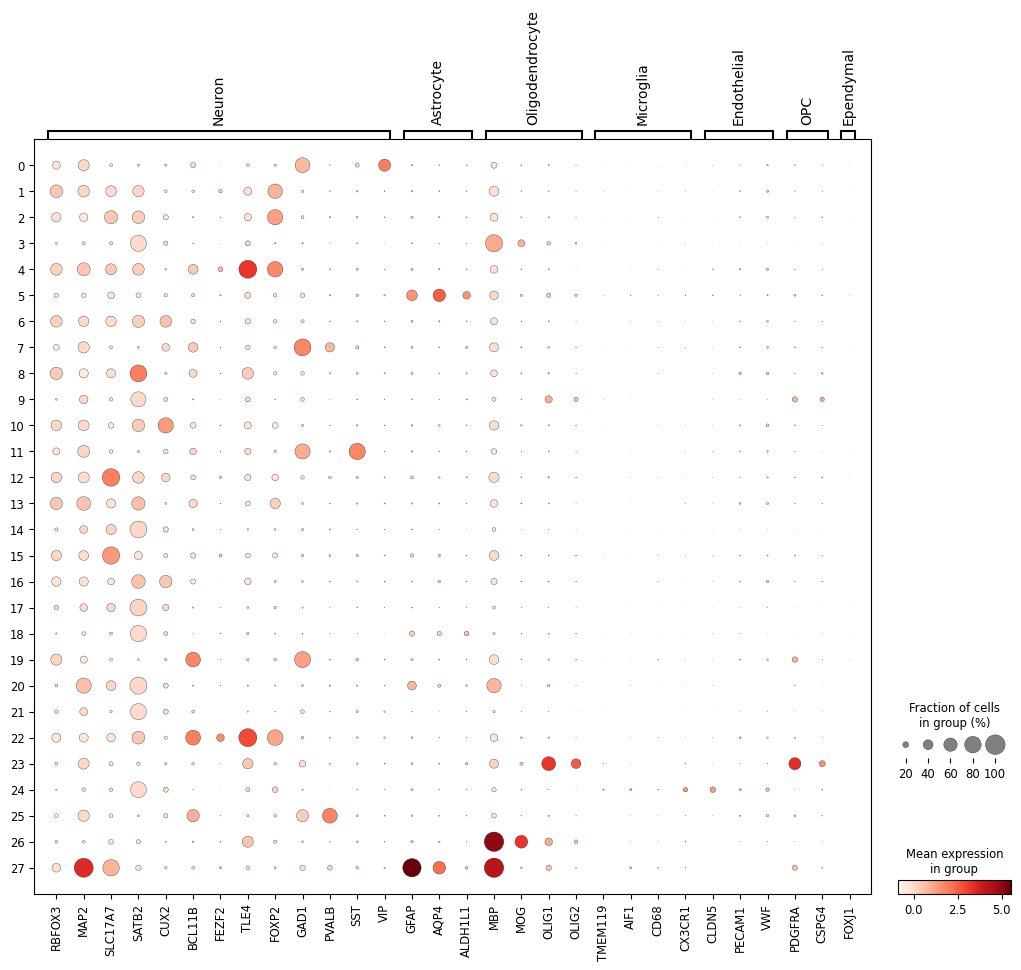

In [4]:
marker_genes_dict = {
    "Neuron": ["RBFOX3", "MAP2", "SLC17A7", "SATB2", "CUX2","BCL11B", "FEZF2","TLE4", "FOXP2","GAD1","PVALB","SST","VIP"],
    "Astrocyte": ["GFAP", "AQP4", "ALDH1L1"],
    "Oligodendrocyte": ["MBP", "MOG", "OLIG1", "OLIG2"],
    "Microglia": ["TMEM119", "AIF1", "CD68", "CX3CR1"],
    "Endothelial": ["CLDN5", "PECAM1", "VWF"],
    "OPC": ["PDGFRA", "CSPG4"],
    "Ependymal": ["FOXJ1"]
}
sc.pl.dotplot(adata, marker_genes_dict, "leiden")

In [7]:
GPCR_adata=anndata.AnnData(X=GPCR_df)
GPCR_adata_norm=sc.pp.normalize_total(GPCR_adata,target_sum=1e4,inplace=False)['X']
GPCR_adata_norm_df=pd.DataFrame(GPCR_adata_norm,columns=GPCR_adata.var.index)

In [ ]:
def sim_inhibit_pattern(adata,GPCR_adata_norm_df,GPCR_type_df,drug_conc,n_pattern=10000):
    # 前提：以下の変数は既に定義されているものとする
    # adata: シングルセル解析の AnnData オブジェクト（obs に "is_clz_selective" などが含まれる）
    # GPCR_adata_norm_df: 正規化済み GPCR 発現データの DataFrame（行=細胞, 列=受容体名）
    # GPCR_type_df: 受容体タイプの DataFrame（列: receptor_name, type）; type は "Gs", "Gi" 等
    # drug_conc: 薬剤濃度（scalar）
    # ※ D_R_mtx は本コードでは使用せず、effective Ki 値によりシミュレーションする
    from tqdm import tqdm  # 追加：進捗バー用ライブラリ
    # 1. adata.obs の "is_clz_selective" に基づき、グループ分けするためのマスクを作成
    mask = adata.obs['is_clz_selective'].astype(bool) == True
    mask.index = pd.RangeIndex(start=0, stop=adata.obs['is_clz_selective'].shape[0], step=1)
    # 2. GPCRのリストおよび GPCR_type_df のフィルタリング
    # "Unnamed: 0" を除外したカラムリストを作成
    GPCR_list2 = [col for col in GPCR_adata_norm_df.columns if col != "Unnamed: 0"]
    # 全細胞の GPCR 発現データ（正規化済み）の DataFrame を用意
    # ※ GPCR_adata_norm_df の index と adata.obs_names が整合している前提
    all_expr = pd.DataFrame(GPCR_adata_norm_df, index=GPCR_adata_norm_df.index, columns=GPCR_list2)

    #GPCR_type_df = GPCR_type_df[GPCR_type_df.receptor_name.isin(GPCR_list2)]
    Gs = GPCR_type_df[GPCR_type_df.type == "Gs"]["receptor_name"].values
    Gi = GPCR_type_df[GPCR_type_df.type == "Gi"]["receptor_name"].values
    # expression_df に存在し、かつ effective_Ki にも存在する GPCR のみを抽出
    Gs_filtered = [gene for gene in Gs if (gene + '_raw' in all_expr.columns)]
    Gi_filtered = [gene for gene in Gi if (gene + '_raw' in all_expr.columns)]

    # フィルタ後のリストから、expression_df の列名用リストを作成
    Gs_cols = [gene + '_raw' for gene in Gs_filtered]
    Gi_cols = [gene + '_raw' for gene in Gi_filtered]

    # 4. ランダムな受容体阻害パターンを 10,000 パターン生成
    unique_patterns_set = set()
    pattern_dict = {}
    i = 0
    #n_pattern=10
    while len(unique_patterns_set) < n_pattern:
        random_pattern = np.random.randint(2, size=len(GPCR_list2))
        pattern_str = ''.join(map(str, random_pattern))
        if pattern_str not in unique_patterns_set:
            unique_patterns_set.add(pattern_str)
            # 各パターンは、受容体ごとに True (阻害する) / False (阻害しない) の辞書とする
            pattern_dict[f"Pattern_{i+1}"] = {gpcr: bool(val) for gpcr, val in zip(GPCR_list2, random_pattern)}
            i += 1

    # オプション：最初の5パターンを確認
    for key in list(pattern_dict.keys())[:5]:
        print(f"{key}: {pattern_dict[key]}")

    def simulate_response_all(expression_df, pattern, drug_conc, Gs_cols, Gi_cols):
        """
        expression_df: 各細胞の受容体発現 (DataFrame, 行=細胞, 列=受容体)
        pattern: 受容体阻害パターン（辞書, receptor -> bool, True=阻害する）
        drug_list: 薬剤名のリスト
        drug_conc: 薬剤濃度（scalar）
        Gs, Gi: Gs, Gi タイプ受容体名の配列
        """
        # 阻害パターンに応じた effective Ki の設定
        # 阻害する受容体は Ki = 0.01、阻害しない受容体は Ki = 10000
        #effective_Ki = pd.Series({receptor: (0.01 if pattern[receptor] else 10000)
        #                          for receptor in expression_df.columns})
        effective_Ki = pd.Series({
        receptor: (0.01 if pattern[receptor] else 10000)
        for receptor in expression_df.columns
        })
        #print(effective_Ki)
        responses = {}
        # Gs 効果・Gi 効果を計算
        gs_effect = (expression_df[Gs_cols].divide(1 + drug_conc / effective_Ki[Gs_cols])).sum(axis=1)
        gi_effect = (expression_df[Gi_cols].divide(1 + drug_conc / effective_Ki[Gi_cols])).sum(axis=1)
        basal_cAMP = (expression_df[Gs_cols] - expression_df[Gi_cols]).sum(axis=1)
        cAMPmod = (gs_effect - gi_effect) - basal_cAMP
        #print("cAMPmod")
        #print(cAMPmod.sum())
        
        # 細胞ごとの cAMPmod の Series とする
        responses= cAMPmod
        return responses

    # 6. 各阻害パターンについて、全細胞でシミュレーションした後、clz_selective と非選択細胞間の差分を算出
    results = []
    # tqdm を用いて進捗状況を表示
    for pattern_name, pattern in tqdm(pattern_dict.items(), total=len(pattern_dict), desc="Simulating drug responses"):
        # 全細胞でのシミュレーション結果を得る
        all_responses = simulate_response_all(all_expr, pattern, drug_conc, Gs_cols, Gi_cols)
        #print(all_responses)
        # 各薬剤について、mask_aligned を用いて clz_selective と非選択細胞群の平均値を計算
        selective_mean = all_responses[mask].mean()
        nonselective_mean = all_responses[~mask].mean()
        diff= selective_mean - nonselective_mean
        #print(diff)
        results.append({
            'pattern_name':pattern_name,
            'pattern': pattern,
            'diff': diff
        })

    # 7. 結果を DataFrame に変換し、diff の大きい順にソート
    results_df = pd.DataFrame(results)
    results_df_sorted = results_df.sort_values(by='diff', ascending=False)

    # 上位のパターンを確認（例：上位5件）
    print(results_df_sorted.head())

    return results_df_sorted,all_responses

In [8]:
#import calculation_tool as ct

drug_conc=10**4
results_df_sorted,all_responses=ct.sim_inhibit_pattern(adata,GPCR_adata_norm_df,GPCR_type_df,drug_conc,n_pattern=10000)

Pattern_1: {'HTR1A_raw': False, 'HTR1B_raw': True, 'HTR1D_raw': True, 'HTR1E_raw': True, 'HTR2A_raw': True, 'HTR2B_raw': True, 'HTR2C_raw': False, 'HTR3A_raw': True, 'HTR4_raw': False, 'HTR5A_raw': True, 'HTR6_raw': False, 'HTR7_raw': False, 'DRD1_raw': True, 'DRD2_raw': True, 'DRD3_raw': True, 'DRD4_raw': True, 'DRD5_raw': True, 'HRH1_raw': True, 'HRH2_raw': False, 'HRH3_raw': False, 'CHRM1_raw': True, 'CHRM2_raw': True, 'CHRM3_raw': True, 'CHRM4_raw': False, 'CHRM5_raw': False, 'ADRA1A_raw': False, 'ADRA1B_raw': False, 'ADRA2A_raw': True, 'ADRA2B_raw': True, 'ADRA2C_raw': False, 'ADRB1_raw': False, 'ADRB2_raw': False}
Pattern_2: {'HTR1A_raw': True, 'HTR1B_raw': True, 'HTR1D_raw': True, 'HTR1E_raw': False, 'HTR2A_raw': True, 'HTR2B_raw': False, 'HTR2C_raw': False, 'HTR3A_raw': False, 'HTR4_raw': True, 'HTR5A_raw': True, 'HTR6_raw': False, 'HTR7_raw': False, 'DRD1_raw': True, 'DRD2_raw': True, 'DRD3_raw': True, 'DRD4_raw': True, 'DRD5_raw': False, 'HRH1_raw': True, 'HRH2_raw': True, 'H

Simulating drug responses: 100%|██████████| 10000/10000 [05:06<00:00, 32.58it/s]

      pattern_name                                            pattern  \
8528  Pattern_8529  {'HTR1A_raw': True, 'HTR1B_raw': False, 'HTR1D...   
4764  Pattern_4765  {'HTR1A_raw': True, 'HTR1B_raw': True, 'HTR1D_...   
6353  Pattern_6354  {'HTR1A_raw': True, 'HTR1B_raw': False, 'HTR1D...   
2965  Pattern_2966  {'HTR1A_raw': True, 'HTR1B_raw': True, 'HTR1D_...   
6959  Pattern_6960  {'HTR1A_raw': False, 'HTR1B_raw': True, 'HTR1D...   

             diff  
8528  1820.577733  
4764  1820.332959  
6353  1820.075571  
2965  1817.855938  
6959  1816.818823  


In [9]:
dir="/data/human_MDD_PFC"
results_df_sorted.to_csv(os.path.join(dir,"results_df_sorted.csv"))
all_responses.to_csv(os.path.join(dir,"all_responses.csv"))

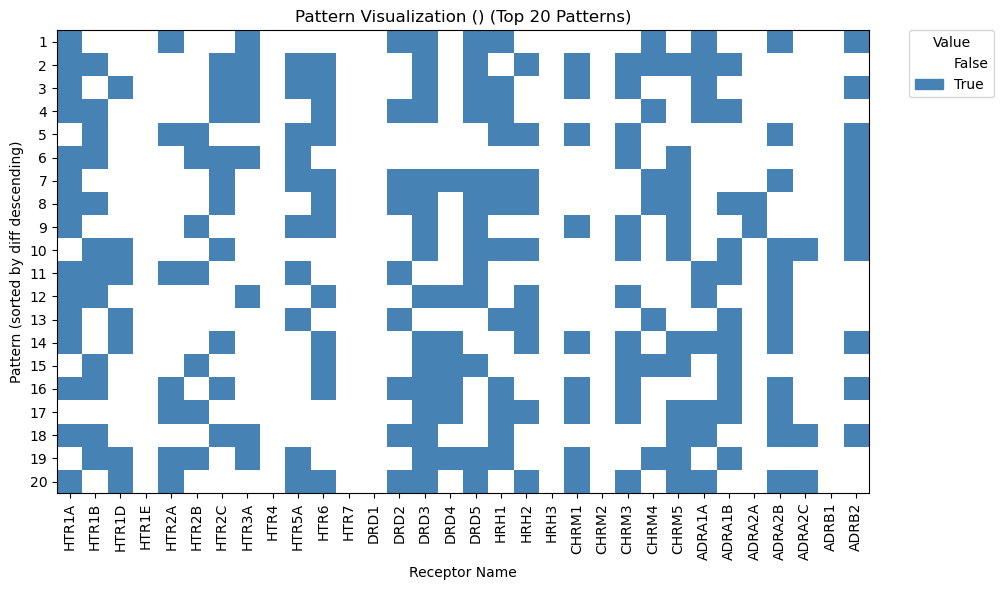

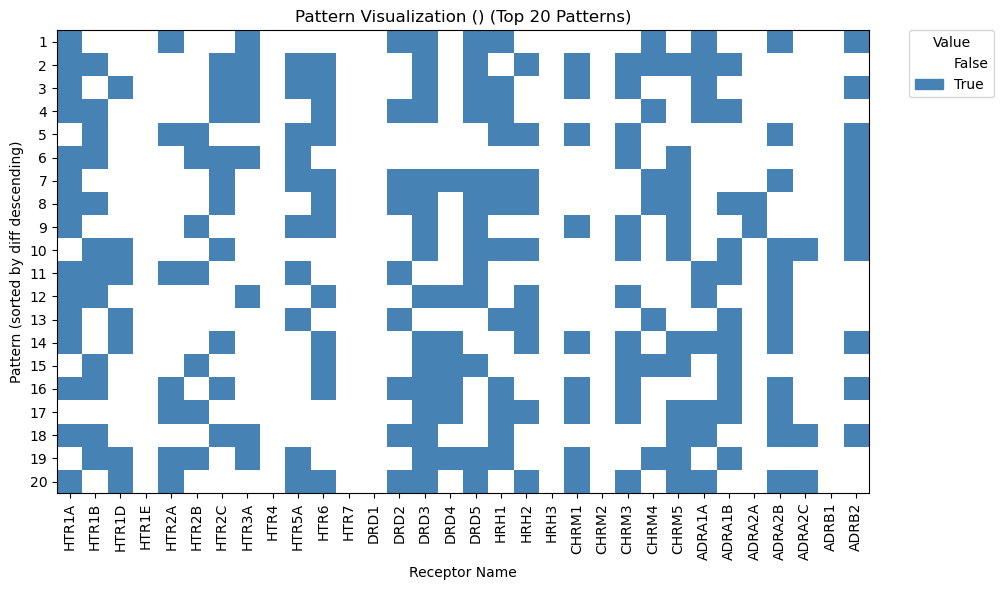

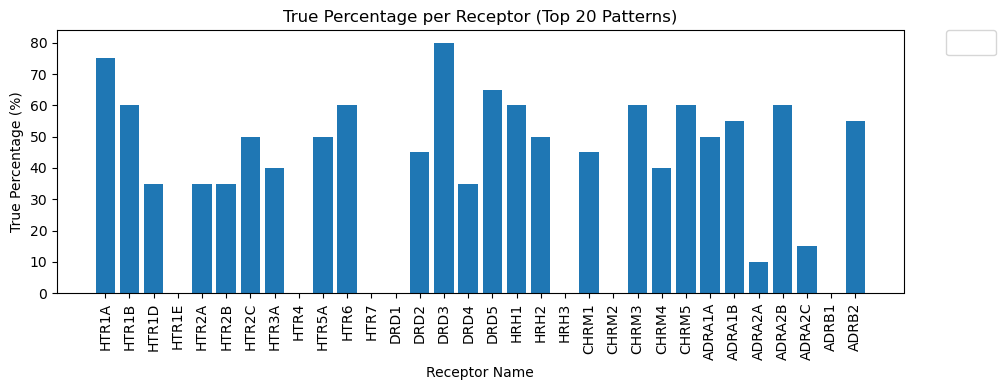

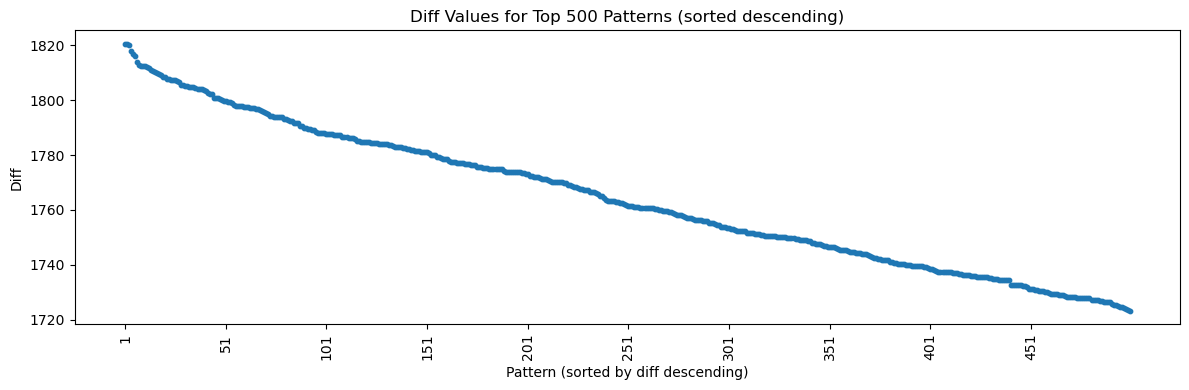

In [10]:
ct.visualize_patterns(results_df_sorted, top_n=20, top_n_for_heatmap=20, scatter_n=500)